In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path
import scipy.stats
import time

from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, fitGMM
from open_spiel.python.examples.ubc_utils import *
import open_spiel.python.examples.ubc_dispatch as dispatch

from auctions.webutils import *

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"


from open_spiel.python.examples.ubc_cma import *

output_notebook()
from open_spiel.python.games.clock_auction_base import InformationPolicy, ActivityPolicy, UndersellPolicy, TiebreakingPolicy
from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_decorators import TakeSingleActionDecorator, TremblingAgentDecorator, ModalAgentDecorator

Loading BokehJS ...

In [22]:
# load runs from experiments
experiments = []
experiments += ['3players_sep1']
runs = []
for experiment in experiments:
    runs += Experiment.objects.get(name=experiment).equilibriumsolverrun_set.all()
print(f"Found {len(runs)} runs")

Found 60 runs


# Analyze runs

In [23]:
# empirical = True
# USE_MODAL = True

records = []
for run in tqdm(runs):
    try:
    
        try:
            game, final_checkpoint, policy = get_results(run, skip_single_chance_nodes=True, load_policy=False)
        except Exception as e:
            print(f"Skipping run {run.name} because of error {e}")
            continue

        record = {
            # clock auction params
            'game_name': run.game.name, 
            'potential': run.config.get('potential_function', 'None'),
            'seed': run.config.get('seed'), 
            'run_name': run.name,
            'experiment': run.experiment.name,
            'config': run.get_config_name(),
            't': final_checkpoint.t,

            # CMA knobs
            'information_policy': InformationPolicy(game.auction_params.information_policy).name,
            'activity_policy': ActivityPolicy(game.auction_params.activity_policy).name,
            'undersell_policy': UndersellPolicy(game.auction_params.undersell_policy).name,
            'tiebreaking_policy': TiebreakingPolicy(game.auction_params.tiebreaking_policy).name,
            'grace_rounds': game.auction_params.grace_rounds,
            'risk_aversion': 'risk' in run.game.name, # TODO: actually read this from players
            'spite': 'spite' in run.game.name, # TODO: actually read this from players
            'clock_speed': game.auction_params.increment,
            'base_game_name': '_'.join(run.game.name.split('/')[1].split('_')[:2]), # Stupid naming convention that will surely bite us later

            # solver information
            'alg': get_algorithm_from_run(run),
            'walltime': run.walltime(),

            # metrics from eval
            # 'total_entropy': total_entropy,

            # stats about history distribution
            # 'avg_distinct_histories': np.mean([len(d) for d in history_dists.values()]),
            # 'avg_history_entropy': np.mean(history_entropies),
        } 
        
        evaluation = final_checkpoint.get_modal_eval()
        
        record['nash_conv'] = evaluation.nash_conv
        record['rewards'] = evaluation.mean_rewards
        record['nash_conv_frac'] = evaluation.nash_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.nash_conv) else np.nan
        record['heuristic_conv'] = evaluation.heuristic_conv
        record['heuristic_conv_frac'] = evaluation.heuristic_conv / sum(evaluation.mean_rewards) if not pd.isnull(evaluation.heuristic_conv) else np.nan
        
        for i in range(game.num_players()):
            record[f'rewards_{i}'] = evaluation.mean_rewards[i]
            record[f'nc_player_improvements_{i}'] = evaluation.nash_conv_player_improvements[i] if not pd.isnull(evaluation.nash_conv) else np.nan
            record[f'nc_player_improvements_frac_{i}'] = (evaluation.nash_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.nash_conv) else np.nan
        
            record[f'hc_player_improvements_{i}'] = evaluation.heuristic_conv_player_improvements[i] if not pd.isnull(evaluation.heuristic_conv) else np.nan
            record[f'hc_player_improvements_frac_{i}'] = (evaluation.heuristic_conv_player_improvements[i] / evaluation.mean_rewards[i]) if not pd.isnull(evaluation.heuristic_conv) else np.nan
          
        record.update(**analyze_samples(evaluation.samples, game))

        records.append(record)
    
        nc = record['nash_conv']
        hc = record['heuristic_conv']
        print(f"NashConv = {(np.nan if pd.isnull(nc) else nc):.2f}; HeuristicConv = {(np.nan if pd.isnull(hc) else hc):.2f}")
    except Exception as e:
        print(f"Something wrong with {run}. Skipping. {e}")
        # raise e
        # break
        import traceback
        print(traceback.format_exc())

print(len(records))

  2%|███▉                                                                                                                                                                                                                                      | 1/60 [00:00<00:22,  2.62it/s]

NashConv = nan; HeuristicConv = 4.87


  3%|███████▊                                                                                                                                                                                                                                  | 2/60 [00:00<00:19,  2.93it/s]

NashConv = nan; HeuristicConv = 0.01


  5%|███████████▋                                                                                                                                                                                                                              | 3/60 [00:00<00:18,  3.13it/s]

NashConv = nan; HeuristicConv = 0.09


  7%|███████████████▌                                                                                                                                                                                                                          | 4/60 [00:01<00:19,  2.87it/s]

NashConv = nan; HeuristicConv = 8.27


 10%|███████████████████████▍                                                                                                                                                                                                                  | 6/60 [00:02<00:17,  3.08it/s]

NashConv = nan; HeuristicConv = 4.88
NashConv = 0.88; HeuristicConv = 0.84


 12%|███████████████████████████▎                                                                                                                                                                                                              | 7/60 [00:02<00:19,  2.71it/s]

NashConv = nan; HeuristicConv = 0.58


 13%|███████████████████████████████▏                                                                                                                                                                                                          | 8/60 [00:02<00:20,  2.57it/s]

NashConv = nan; HeuristicConv = 4.82


 15%|███████████████████████████████████                                                                                                                                                                                                       | 9/60 [00:03<00:19,  2.60it/s]

NashConv = nan; HeuristicConv = 4.23


 17%|██████████████████████████████████████▊                                                                                                                                                                                                  | 10/60 [00:03<00:17,  2.80it/s]

NashConv = nan; HeuristicConv = 0.14


 18%|██████████████████████████████████████████▋                                                                                                                                                                                              | 11/60 [00:03<00:15,  3.08it/s]

NashConv = nan; HeuristicConv = 0.14


 20%|██████████████████████████████████████████████▌                                                                                                                                                                                          | 12/60 [00:04<00:15,  3.12it/s]

NashConv = 8.63; HeuristicConv = 1.86


 22%|██████████████████████████████████████████████████▍                                                                                                                                                                                      | 13/60 [00:04<00:15,  2.96it/s]

NashConv = 14.44; HeuristicConv = 2.90


 23%|██████████████████████████████████████████████████████▎                                                                                                                                                                                  | 14/60 [00:04<00:16,  2.79it/s]

NashConv = nan; HeuristicConv = 5.53


 27%|██████████████████████████████████████████████████████████████▏                                                                                                                                                                          | 16/60 [00:05<00:14,  3.03it/s]

NashConv = 18.43; HeuristicConv = 15.70
NashConv = nan; HeuristicConv = 1.12


 30%|█████████████████████████████████████████████████████████████████████▉                                                                                                                                                                   | 18/60 [00:06<00:12,  3.31it/s]

NashConv = nan; HeuristicConv = 1.10
NashConv = nan; HeuristicConv = 0.14


 32%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                                               | 19/60 [00:06<00:12,  3.35it/s]

NashConv = nan; HeuristicConv = 0.14


 33%|█████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                           | 20/60 [00:06<00:12,  3.32it/s]

NashConv = nan; HeuristicConv = 0.67


 35%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                       | 21/60 [00:07<00:13,  2.92it/s]

NashConv = nan; HeuristicConv = 0.17


 38%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                               | 23/60 [00:07<00:10,  3.43it/s]

NashConv = nan; HeuristicConv = 0.00
NashConv = nan; HeuristicConv = 0.00


 40%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                           | 24/60 [00:08<00:11,  3.01it/s]

NashConv = nan; HeuristicConv = 0.79


 42%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                        | 25/60 [00:08<00:10,  3.35it/s]

NashConv = nan; HeuristicConv = 0.47


 43%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                    | 26/60 [00:08<00:12,  2.72it/s]

NashConv = nan; HeuristicConv = 1.09


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                | 27/60 [00:09<00:12,  2.63it/s]

NashConv = nan; HeuristicConv = 1.18


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                            | 28/60 [00:09<00:11,  2.75it/s]

NashConv = 0.03; HeuristicConv = 0.00


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                        | 29/60 [00:10<00:10,  2.86it/s]

NashConv = 0.88; HeuristicConv = 0.03


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                    | 30/60 [00:10<00:10,  2.92it/s]

NashConv = 3.26; HeuristicConv = 1.28


 52%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                | 31/60 [00:10<00:10,  2.89it/s]

NashConv = nan; HeuristicConv = 3.38


 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                            | 32/60 [00:10<00:09,  3.01it/s]

NashConv = nan; HeuristicConv = 0.00


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                     | 38/60 [00:11<00:02,  7.95it/s]

NashConv = nan; HeuristicConv = 0.00
Something wrong with sep1_sep1_3_hide_demand-cfr_port_2_no_extoutcome_lin_avg_plus-102 (3players_sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9949/1734247546.py", line 47, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.

Something wrong with sep1_sep1_3_hide_demand-cfr_port_2_no_extoutcome_li

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 40/60 [00:11<00:02,  7.85it/s]

NashConv = nan; HeuristicConv = 0.14
Something wrong with sep1_sep1_4_hide_demand-cfr_port_2_no_extoutcome_lin_avg_plus-100 (3players_sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9949/1734247546.py", line 47, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.

Something wrong with sep1_sep1_4_hide_demand-cfr_port_2_no_extoutcome_li

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 45/60 [00:12<00:01,  8.71it/s]

NashConv = nan; HeuristicConv = 2.01


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 49/60 [00:12<00:01,  9.07it/s]

NashConv = nan; HeuristicConv = 0.42
Something wrong with sep1_sep1_1_hide_demand-cfr_port_2_no_extoutcome_lin_avg-102 (3players_sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9949/1734247546.py", line 47, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.

Something wrong with sep1_sep1_3_hide_demand-cfr_port_2_no_extoutcome_lin_avg

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 51/60 [00:13<00:01,  7.21it/s]

NashConv = nan; HeuristicConv = 0.59
Something wrong with sep1_sep1_0_hide_demand-cfr_port_2_no_extoutcome_lin_avg_plus-100 (3players_sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9949/1734247546.py", line 47, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.

Something wrong with sep1_sep1_0_hide_demand-cfr_port_2_no_extoutcome_li

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 54/60 [00:13<00:00,  7.38it/s]

NashConv = nan; HeuristicConv = 4.00


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 55/60 [00:14<00:00,  5.32it/s]

NashConv = nan; HeuristicConv = 15.08


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 58/60 [00:14<00:00,  5.90it/s]

NashConv = nan; HeuristicConv = 0.12
Something wrong with sep1_sep1_0_hide_demand-cfr_port_2_no_extoutcome_lin_avg_plus-102 (3players_sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9949/1734247546.py", line 47, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.

NashConv = nan; HeuristicConv = 0.67


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:14<00:00,  4.04it/s]

NashConv = nan; HeuristicConv = 0.00
Something wrong with sep1_sep1_2_hide_demand-cfr_port_2_no_extoutcome_lin_avg_plus-101 (3players_sep1). Skipping. Evaluation matching query does not exist.
Traceback (most recent call last):
  File "/tmp/ipykernel_9949/1734247546.py", line 47, in <module>
    evaluation = final_checkpoint.get_modal_eval()
  File "/apps/open_spiel/web/auctions/auctions/models.py", line 96, in get_modal_eval
    return self.evaluation_set.get(name=modal_name)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/manager.py", line 85, in manager_method
    return getattr(self.get_queryset(), name)(*args, **kwargs)
  File "/home/ubuntu/.pyenv/versions/3.8.2/envs/venv/lib/python3.8/site-packages/django/db/models/query.py", line 439, in get
    raise self.model.DoesNotExist(
auctions.models.Evaluation.DoesNotExist: Evaluation matching query does not exist.

44


In [26]:
df = pd.DataFrame.from_records(records)

In [27]:
df['rule_set'] = df.apply(lambda row: row.game_name.split(row.base_game_name)[1][1:-5], axis=1)

In [28]:
def describe_nc(df):
    print("NC")
    print(df['nash_conv'].describe())
    
    print("HC when NC is not null")
    print(df.query('~nash_conv.isnull()')['heuristic_conv'].describe())
    
    print("HC when NC is null")
    print(df.query('nash_conv.isnull()')['heuristic_conv'].describe())
    
    print("HC overall")
    print(df['heuristic_conv'].describe())
    print()
    
    


# Overall
print("OVERALL")
describe_nc(df)

# Did biasing towards heuristics help?
no_bias = df.query('config.str.contains("cfr_port_2_no_ext")')
print("NO BIAS")
describe_nc(no_bias)

yes_bias = df.query('config.str.contains("cfr_port_3")')
print("YES BIAS")
describe_nc(yes_bias)


OVERALL
NC
count     7.000000
mean      6.650561
std       7.363352
min       0.032836
25%       0.881866
50%       3.255481
75%      11.534798
max      18.432285
Name: nash_conv, dtype: float64
HC when NC is not null
count     7.000000
mean      3.230277
std       5.590856
min       0.000000
25%       0.435677
50%       1.284916
75%       2.379913
max      15.695844
Name: heuristic_conv, dtype: float64
HC when NC is null
count    37.000000
mean      1.813600
std       3.039643
min       0.000000
25%       0.137255
50%       0.578431
75%       2.005345
max      15.077540
Name: heuristic_conv, dtype: float64
HC overall
count    44.000000
mean      2.038981
std       3.517330
min       0.000000
25%       0.137255
50%       0.629111
75%       2.229930
max      15.695844
Name: heuristic_conv, dtype: float64

NO BIAS
NC
count     7.000000
mean      6.650561
std       7.363352
min       0.032836
25%       0.881866
50%       3.255481
75%      11.534798
max      18.432285
Name: nash_conv, dtyp

In [9]:
df.heuristic_conv.describe()

count    195.000000
mean       3.329215
std        5.492855
min        0.000000
25%        0.364938
50%        1.022989
75%        3.769000
max       32.920099
Name: heuristic_conv, dtype: float64

Text(0, 0.5, 'HeuristicConv')

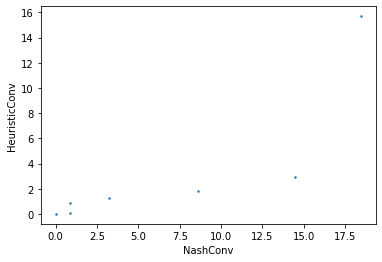

In [8]:
plt.scatter(
    df.nash_conv.values,
    df.heuristic_conv.values,
    s=2
)
plt.xlabel('NashConv')
plt.ylabel('HeuristicConv')

In [9]:
# TODO: Maybe actually make this readable?
df['variant'] = list(map(str,(zip(df.information_policy, df.clock_speed, df.activity_policy, df.undersell_policy, df.tiebreaking_policy, df.risk_aversion, df.grace_rounds))))
palette = dict()

colors = ['red', 'blue', 'magenta', 'green', 'orange']

for i, v in enumerate(df['variant'].unique()):
    palette[v] = colors[i]

In [31]:
# Need to a) Remove "bad" entries b) Be careful about comparisons that are missing datapoints 
df_plt = df

In [37]:
### Remove bad entries
good_thresh = 0.1
# good_thresh_abs = 5
# df_plt = df.query(f'player_improvements_0 < {good_thresh_abs} and player_improvements_1 < {good_thresh_abs}')
df_plt = df.query(f'hc_player_improvements_frac_0 < {good_thresh} and hc_player_improvements_frac_1 < {good_thresh} and hc_player_improvements_frac_2 < {good_thresh}')
# df_plt = df.query(f'nash_conv_frac < {good_thresh}')
len(df), len(df_plt)

# (df.groupby('game_name').size() - df_plt.groupby('game_name').size()).sort_values()

(44, 36)

In [12]:
# df.query('activity_policy == "OFF"')['nash_conv_frac']
# df.query('undersell_policy == "UNDERSELL" and information_policy == "SHOW_DEMAND" and activity_policy == "ON" and clock_speed == 0.3 ')[['t', 'nash_conv', 'nash_conv_frac']]

27


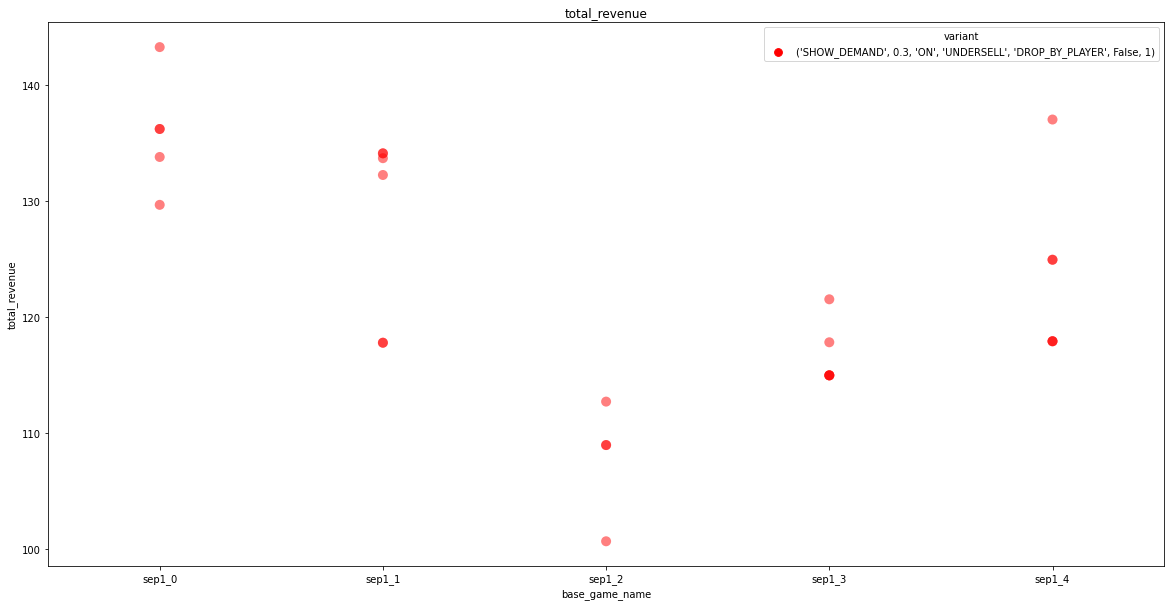

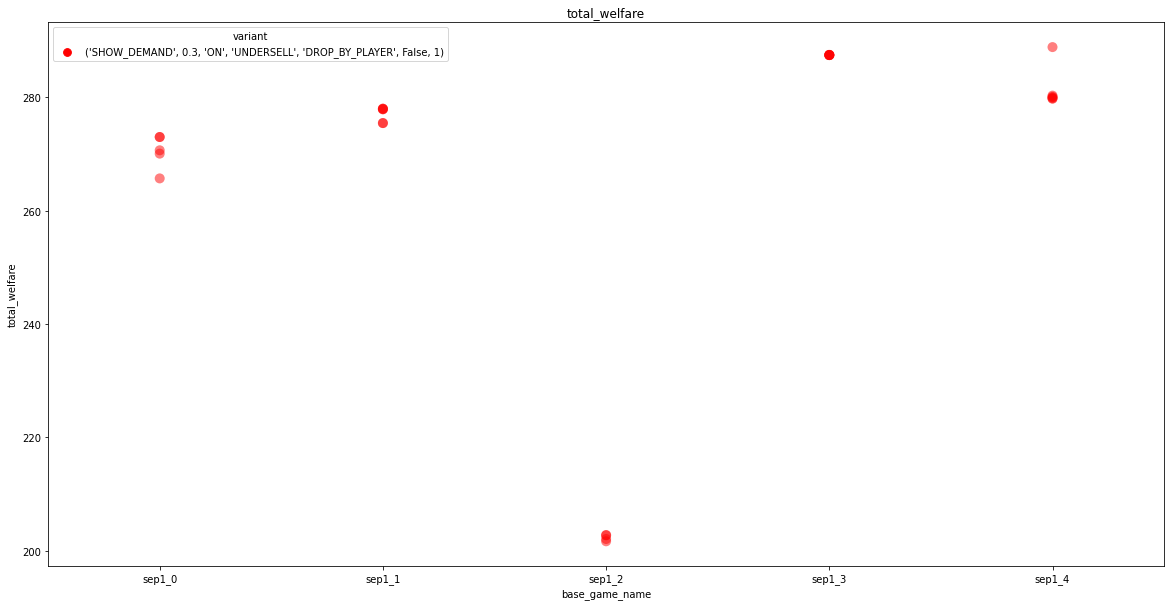

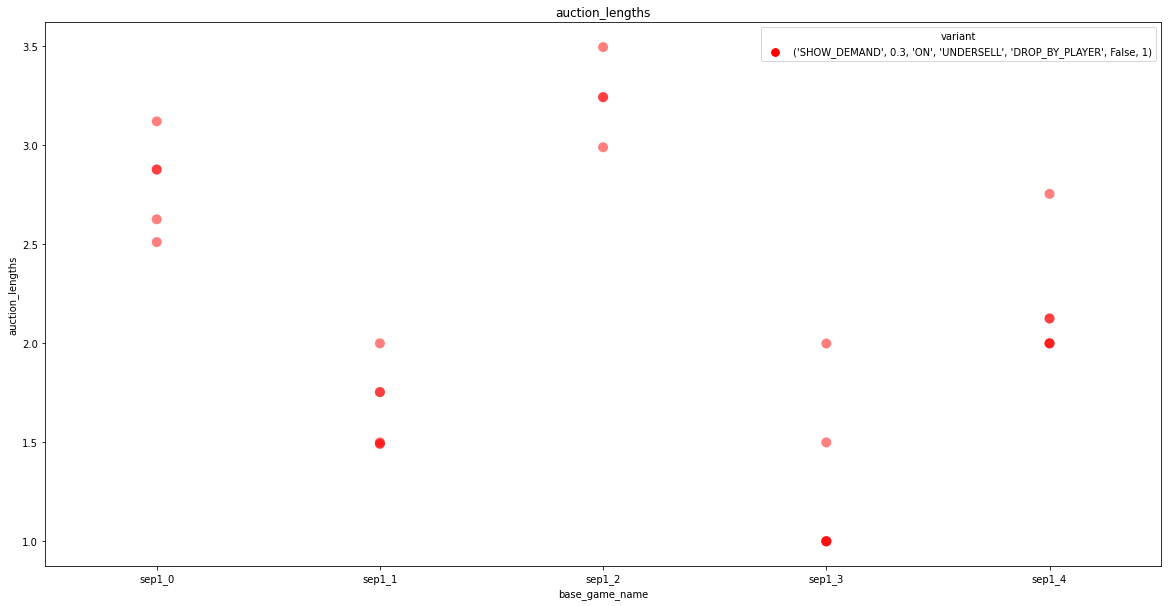

In [17]:
ATTRIBUTE = 'variant'
NORMALIZED = False
plot_type = 'scatter'
box_df = df_plt.copy()
markers = ['o', 'X', '^']

# TODO: These strings are getting unwieldy

# Vanilla for clock
CLOCK_QUERY = 'information_policy == "SHOW_DEMAND" and activity_policy == "ON" and undersell_policy == "UNDERSELL" and grace_rounds == 1 and tiebreaking_policy == "DROP_BY_PLAYER"'
# box_df = box_df.query(CLOCK_QUERY)

# # Check undersell
UNDERSELL_QUERY = 'information_policy == "SHOW_DEMAND" and activity_policy == "ON" and clock_speed == 0.3 and grace_rounds == 1'
# box_df = box_df.query(UNDERSELL_QUERY)

# # Check activity
ACTIVITY_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and grace_rounds == 1'
# box_df = box_df.query(ACACTIVITY_QUERY)

# # Check tiebreaking
TIEBREAKING_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and activity_policy == "ON" and grace_rounds == 1'
# box_df = box_df.query(TIEBREAKING_QUERY)

# Check grace
GRACE_QUERY = 'information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and activity_policy == "ON" and tiebreaking_policy == "DROP_BY_PLAYER" and not risk_aversion'
# box_df = box_df.query(GRACE_QUERY)

# Activity ON vs grace vs activity OFF
box_df = box_df.query('information_policy == "SHOW_DEMAND" and undersell_policy == "UNDERSELL" and clock_speed == 0.3 and tiebreaking_policy == "DROP_BY_PLAYER" and not risk_aversion')


box_df = box_df.sort_values(['clock_speed', 'game_name', 'config'])

# box_df = box_df.query('alg.str.contains("outcome")')

print(len(box_df))


STATS = ['total_revenue', 'total_welfare', 'auction_lengths']
# Normalize by the mean of the "base" version, so the scales line up better in the same graph
if NORMALIZED: 
    for stat in STATS:
        base = str(('SHOW_DEMAND', 0.3))
        base_stat = box_df.pivot_table(index=['base_game_name'], values=stat, aggfunc='mean', columns=ATTRIBUTE)
        box_df[f'normalized_{stat}'] = box_df.apply(lambda x: x[stat] / base_stat.loc[x['base_game_name'], base], axis=1)

for stat in STATS:
    if NORMALIZED:
        stat = f'normalized_{stat}'
    plt.figure(figsize=(20,10))
    if plot_type == 'box':
        ax = sns.boxplot(data=box_df, x='base_game_name', y=stat, hue=ATTRIBUTE)
        # ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    else:
        strip_kwargs = dict(x='base_game_name', y=stat, hue=ATTRIBUTE, s=10, alpha=0.5, dodge=True, jitter=False, palette=palette)
        sns.stripplot(data=box_df, **strip_kwargs)
        # for i, config in enumerate(box_df['config'].unique()):
        #     # print(config, markers[i])
        #     # TODO: If no entries exist, this pushes colours to the wrong positions
        #     ax = sns.stripplot(data=box_df.query(f'config == "{config}"'), marker=markers[i], **strip_kwargs)
        #     if i == 0:
        #         old_handles, old_labels = ax.get_legend_handles_labels()
        # ax.legend(old_handles, old_labels)

    plt.title(f"{stat}")

In [38]:
# 1) Get max/min for each valuation/treatment pairing over each stat

# First query down to relevant datapoints. Then groupby rule change and SATS =(game_name) and max/min?
metrics = ['total_revenue', 'total_welfare', 'auction_lengths']
for i in range(3): # TODO:
    metrics += [f'p{i}_utility', f'p{i}_payment']

for query in [CLOCK_QUERY, UNDERSELL_QUERY, ACTIVITY_QUERY, TIEBREAKING_QUERY, GRACE_QUERY]: 
    clock_df = df_plt.query(query)
    data = dict()
    for metric in metrics:
        data[f'max_{metric}'] = clock_df.groupby(['rule_set', 'base_game_name'])[metric].max()
        data[f'min_{metric}'] = clock_df.groupby(['rule_set', 'base_game_name'])[metric].min()

    heatmap_df = pd.DataFrame(data) 
    
    for rule_set in heatmap_df.reset_index()['rule_set'].unique():
        if rule_set != 'base':
            cmap_norm = plt.matplotlib.colors.TwoSlopeNorm(vmin=0.5, vcenter=1, vmax=2)
            plt.figure(figsize=(12, 8))
            plt.imshow((heatmap_df.loc[rule_set] / heatmap_df.loc['base']).values.T, cmap='RdBu', norm=cmap_norm)
            plt.title(rule_set)
            plt.yticks(range(len(heatmap_df.loc['base'].columns)), heatmap_df.loc['base'].columns)
            plt.colorbar()
            plt.show()


In [39]:
for rule_set in heatmap_df.reset_index()['rule_set'].unique():
    if rule_set != 'base':

        cmap_norm = plt.matplotlib.colors.TwoSlopeNorm(vmin=0.6, vcenter=1, vmax=1.4)
        plt.figure(figsize=(12, 8))
        plt.imshow((heatmap_df.loc[rule_set] / heatmap_df.loc['base']).values.T, cmap='RdBu', norm=cmap_norm)
        plt.title(rule_set)
        plt.yticks(range(len(heatmap_df.loc['base'].columns)), heatmap_df.loc['base'].columns)
        plt.colorbar()
        plt.show()


In [41]:
df_plt['rule_set'].value_counts()

def rule_set_to_value_structure(s):
    if 'spite' in s:
        return 'spite'
    elif 'risk_averse' in s:
        return 'risk_averse'
    else:
        return 'quasi_linear'

def rule_set_to_rule(s):
    if 'high_speed' in s:
        return 'high_speed'
    elif 'medium_speed' in s:
        return 'medium_speed'
    elif 'grace' in s:
        return 'grace'
    elif 'tie_break' in s:
        return 'tie_break'
    elif 'undersell_allowed' in s:
        return 'undersell_allowed'
    elif 'hide_demand' in s:
        return 'hide_demand'
    elif 'no_activity' in s:
        return 'no_activity'
    else:
        return 'base'
    
    
df_plt['value_structure'] = df_plt['rule_set'].apply(rule_set_to_value_structure)
df_plt['rule'] = df_plt['rule_set'].apply(rule_set_to_rule)

/tmp/ipykernel_9949/4273131473.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plt['value_structure'] = df_plt['rule_set'].apply(rule_set_to_value_structure)
/tmp/ipykernel_9949/4273131473.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plt['rule'] = df_plt['rule_set'].apply(rule_set_to_rule)


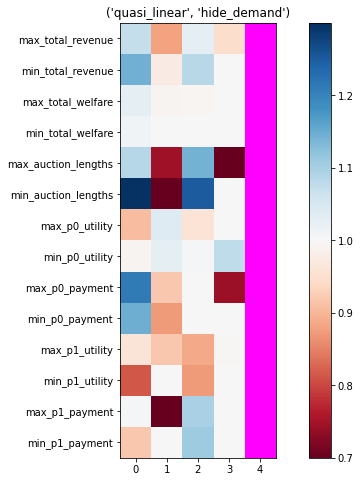

In [42]:
# 1) Get max/min for each valuation/treatment pairing over each stat

# First query down to relevant datapoints. Then groupby rule change and SATS =(game_name) and max/min?
metrics = ['total_revenue', 'total_welfare', 'auction_lengths']
for i in range(2): # TODO:
    metrics += [f'p{i}_utility', f'p{i}_payment']


df_plt_indexed = df_plt.set_index(['value_structure', 'rule']).sort_index().copy()

def make_data_dict(df):
    data = dict()
    for metric in metrics:
        data[f'max_{metric}'] = df.groupby('base_game_name')[metric].max()
        data[f'min_{metric}'] = df.groupby('base_game_name')[metric].min()
    return pd.DataFrame(data)
    
for idx, grp_df in df_plt.groupby(['value_structure', 'rule']):
    if idx[1] == 'base':
        continue
    
    data_grp_df = make_data_dict(grp_df)
    normalizer_grp_df = df_plt_indexed.loc[(idx[0], 'base')]
    data_normalized_df = make_data_dict(normalizer_grp_df)
    
    cmap_norm = plt.matplotlib.colors.TwoSlopeNorm(vmin=0.7, vcenter=1, vmax=1.3)
    cmap = plt.cm.get_cmap('RdBu').copy()
    cmap.set_bad('magenta')
    plt.figure(figsize=(12, 8))
    plt.imshow((data_grp_df / data_normalized_df).values.T, cmap=cmap, norm=cmap_norm)
    plt.title(idx)
    plt.yticks(range(len(data_grp_df.columns)), data_grp_df.columns)
    plt.colorbar()
    plt.show()

    
# for query in [CLOCK_QUERY, UNDERSELL_QUERY, ACTIVITY_QUERY, TIEBREAKING_QUERY, GRACE_QUERY]: 
#     clock_df = df_plt.query(query)
#     data = dict()
#     for metric in metrics:
#         data[f'max_{metric}'] = clock_df.groupby(['rule_set', 'base_game_name'])[metric].max()
#         data[f'min_{metric}'] = clock_df.groupby(['rule_set', 'base_game_name'])[metric].min()

#     heatmap_df = pd.DataFrame(data) 
    
